# Composable Blocks

This is a simple illustration of the python API for Blocks.

## What are Blocks?
Blocks are composable layout elements for easily building HTML, PDF, PNG and JPG based reports.
At the same time, all block constructs can be rendered in-line in IPython Notebooks.
This has practical benefits like a single backtest function that can be used for quick analysis during research work in a notebook, but also directly injected into more formal reports with having to fumble around with intermediate formats.

Practically all the functionality is based on `HTML` rendering.
HTML is a declarative, tree based language that is easy to work with and fungible.
Blocks are also declarative, composable into a tree and are meant to be dead simple.
The match was thus quite natural.

The blocks do not try to match the power and precision of latex.
Such an undertaking would be not only out of the scope of a simple library, but would mean the reinvention of latex with all the gnarliness that comes with it.

## Imports & Data
To get started with pybloqs, you will want to `import pybloqs`{l=python}. We'll also use `import numpy as np`{l=python} and `import pandas as pd`{l=python} in this document.

In [1]:
%%capture
from datetime import datetime

import numpy as np
import pandas as pd

import pybloqs

df = pd.DataFrame(
    (np.random.rand(200, 4) - 0.5) / 10,
    columns=list("ABCD"),
    index=pd.date_range(datetime(2000, 1, 1), periods=200),
)

df_cr = (df + 1).cumprod()

a = df_cr.A
b = df_cr.B
c = df_cr.C
c.name = "C"

## Individual blocks
We start with the obligatory "Hello World!".

Throughout we have highlighted the background of the blocks with colour `#eee` (light grey) to distinguish the output of the cell from the rest of this document.
You can set `css` styles on your blocks by passing keyword arguments to `Block`.

In [2]:
pybloqs.Block("Hello World!", background="#eee")

Any `css` property can be used. Lets change the alignment and font weight.

In [3]:
pybloqs.Block("Hello World!", text_align="right", font_weight="bold", background="#eee")

All blocks support a title. 

In [4]:
pybloqs.Block("Hello World!", title="Announcement", title_level=3, background="#eee")

We can pass a dataframe to `Block`

In [5]:
pybloqs.Block(df.head(), background="#eee")

,A,B,C,D
2000-01-01 00:00:00,0.02,-0.05,0.04,-0.02
2000-01-02 00:00:00,0.02,0.01,0.00,0.03
2000-01-03 00:00:00,-0.00,0.01,-0.01,-0.03
2000-01-04 00:00:00,-0.00,0.01,0.00,0.04
2000-01-05 00:00:00,0.01,-0.00,0.02,-0.04


Or matplotlib plots


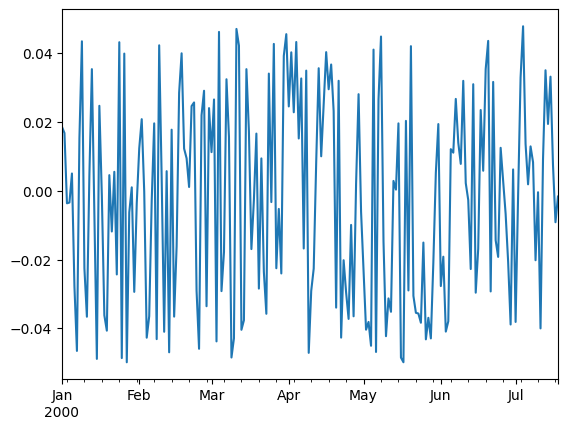

In [6]:
pybloqs.Block(df.A.plot(), background="#eee")

Raw HTML output

In [7]:
pybloqs.Block("<i>This</i> block has <code>html</code>", background="#eee")

## Composing blocks

Pybloqs' power comes with its ability to _compose_ individual blocks into larger reports.

There are a number of block types such as `VStack` and `HStack` you can use to do this.

In [8]:
pybloqs.VStack(
    [
        pybloqs.Block("Hello World!", title="Announcement", title_level=3),
        pybloqs.Block("<b>this text is bold</b>"),
    ],
    background="#eee",
)

In fact, the `pybloqs.Block` helper method, lets you pass in a list and it will vertically stack the blocks. Here we can even just pass in strings which will be "blockified" before being composed.

In [9]:
pybloqs.Block([f"Block {i}" for i in range(8)], background="#eee")

We can split the list into multiple columns:

In [10]:
pybloqs.Block([f"Block {i}" for i in range(8)], cols=4, background="#eee")

Layout styling is cascading - styles will cascade from parent blocks to child blocks by default. This behavior can be disabled by setting *inherit_cfg* to false on the child blocks, or simply specifying the desired settings explicitly.

In [11]:
pybloqs.Block(
    [f"Block {i}" for i in range(8)], cols=4, text_align="right", background="#eee"
)

Using specific block types is simple as well. As an example - the Paragraph block:

In [12]:
pybloqs.Block(
    [
        pybloqs.Paragraph("First paragraph."),
        pybloqs.Paragraph("Second paragraph."),
        pybloqs.Paragraph("Third paragraph."),
    ],
    text_align="right",
    background="#eee",
)

The Pre block preserves whitespace formatting and is rendered using a fixed width font. Useful for rendering code-like text.

In [13]:
pybloqs.Pre("""
some:
  example:
    yaml: [1,2,3]
  data: "text"
""")

Creating custom blocks is trivial. For the majority of the cases, one can just inherit from the Container block, which has most of the plumbing already in place:

In [15]:
class Capitalize(pybloqs.Raw):
    def __init__(self, contents, **kwargs):
        # Stringify and capitalize
        contents = str(contents).upper()

        super().__init__(contents, **kwargs)


Capitalize("this here text should look like shouting!")

In [16]:
# Emails a block (or a report consisting of many blocks).
# The emailing is independent of previous reports being
# saved (e.g. there is no need to call save before emailing).
from smtplib import SMTPServerDisconnected

try:
    pybloqs.Block("").email()
except SMTPServerDisconnected:
    display(
        "Please create ~/.pybloqs.cfg with entry for 'smtp_server'. See README.md and pybloqs/config.py for details."
    )

"Please create ~/.pybloqs.cfg with entry for 'smtp_server'. See README.md and pybloqs/config.py for details."

## Page break

In [17]:
blocks = [
    pybloqs.Block("First page", styles={"page-break-after": "always"}),
    pybloqs.Block("Second page"),
]
r = pybloqs.VStack(blocks)
r.save("two_page_report.pdf")

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


'two_page_report.pdf'